In [1]:
import pandas as pd
import re
import pickle
import datetime
#import textdistance
import json
import numpy as np
import wikipedia as wiki
path_data= 'C:/root/Universita/project_dmdv/data/'




#some useful functions

#funzione per la sostituzione sulla base di una regex, la funzione nativa va in errore se il valore è null
def regex_replace(regex, sub, string):
    if pd.isnull(string):
        return None
    else:
        return re.sub(regex, sub, string)

#funzione per la sostituzione sulla base di una regex, la funzione nativa va in errore se il valore è stringa vuota
def regex_replace2(regex, sub, string):
    if pd.isnull(string):
        return ''
    else:
        return re.sub(regex, sub, string)
    
#matching sulla base di una regex, la f nativa va in errore se il valore è mancante
def regex_match(regex, string, reverse = False):
    if pd.isnull(string):
        return None
    else:
        return re.match(regex, string)
    
#is_winner
def get_winner(string):
    if string:
        return 'Winner'
    else:
        return 'Nominee'

#funzione per la sostituzione delle stringe contententi solo spazi
def replace_na_string(string):
    str_out = string
    if pd.notnull(string):
        if string.replace(' ', '') == '':
            str_out = None
    return str_out

#estrazione sottostringa (se pd.NoneType, lo slicing di python base va in errore)
def substring(string, start, end):
    str_out = None
    if pd.notnull(string):
        str_out = string[start:end]
    return str_out

#controllare se una stringa e' dentro l'altra
def regex_is_in(regex, string, reverse = True):
    if pd.isnull(string):
        return False == reverse
    else:
        if re.match(regex, string):
            return True == reverse
        else:
            return False == reverse

#conversione in tipo data (con eventuale pulizia se va in errore)
def get_date(date):
    try:
        date_out = pd.to_datetime(date, format = "%Y-%m-%d")
    except:
        date_list = date.split('-')
        if date_list[0][:2] == '10':
            date_list[0] = '19' + date_list[0][-2:]
        elif date_list[0][:2] == '00':
            date_list[0] = '20' + date_list[0][-2:]
        elif len(date_list[0]) > 4:
            date_list[0] = date_list[0][:2] + date_list[0][-2:]
        date_out = pd.to_datetime('-'.join(date_list), format = "%Y-%m-%d")
    return date_out

# IMPORT

##### Awards

In [2]:
data_award = pd.read_pickle(path_data + 'awards/tv_series_awards.data')
data_award['program'] = data_award['program'].apply(lambda row: replace_na_string(row))
data_award['title_upper'] = data_award['title_upper'].apply(lambda row: replace_na_string(row))
data_award.head()

,award,year,program,person,is_winner,type,award_type,title_upper,award_id
0,Comedy - Comedy Series,2019.0,Barry,"[Alec Berg, Bill Hader, Aida Rodgers, Emily He...",Nominee,T,emmy award,BARRY,aw-14028
1,Comedy - Comedy Series,2019.0,Fleabag,"[Phoebe Waller-Bridge, Harry Bradbeer, Lydia H...",Winner,T,emmy award,FLEABAG,aw-14029
2,Comedy - Comedy Series,2019.0,Russian Doll,"[Natasha Lyonne, Leslye Headland, Amy Poehler,...",Nominee,T,emmy award,RUSSIAN DOLL,aw-14030
3,Comedy - Comedy Series,2019.0,Schitt's Creek,"[Eugene Levy, Daniel Levy, David West Read, An...",Nominee,T,emmy award,SCHITT'S CREEK,aw-14031
4,Comedy - Comedy Series,2019.0,The Good Place,"[Michael Schur, David Miner, Morgan Sackett, D...",Nominee,T,emmy award,THE GOOD PLACE,aw-14032


In [3]:
#split per i premi con nome mancante
data_award_naName = data_award.copy()[pd.isnull(data_award['title_upper'])]
data_award = data_award[pd.notnull(data_award['title_upper'])]

print('Totali: ' + str(data_award_naName.shape[0] + data_award.shape[0]))
print('Missing: ' + str(data_award_naName.shape[0]))
print('Non missing: ' + str(data_award.shape[0]))

Totali: 10513
Missing: 6
Non missing: 10507


##### TV Series

In [4]:
tv_series_original = pd.read_json(path_data + 'tmdb/json/tmdb_tvs.json')[
    ['first_air_date','id', 'last_air_date', 'name', 'original_name', 'popularity', 'series_id']]
tv_series_original.columns = ['first_air_date','id', 'last_air_date', 'title', 'original_title', 'popularity', 'title_id']

In [5]:
#tipi di errore per cui serve la funzione get_date
l = []
for i in range(tv_series_original.shape[0]):
    try:
        pd.to_datetime(tv_series_original.iloc[i]['first_air_date'], format = "%Y-%m-%d")
    except:
        l = l + [tv_series_original.iloc[i]['first_air_date'].split('-')[0]]
l

['0002', '0001', '0004', '0004', '20008']

In [6]:
#conversione delle date ed estrazione anno
tv_series_original['first_air_date'] = tv_series_original['first_air_date'].apply(get_date)
tv_series_original['first_year'] = tv_series_original['first_air_date'].apply(lambda row: float(row.year))

tv_series_original['last_air_date'] = tv_series_original['last_air_date'].apply(get_date)
tv_series_original['last_year'] = tv_series_original['last_air_date'].apply(lambda row: float(row.year))

tv_series_original.drop(['last_air_date', 'first_air_date'], inplace = True, axis = 1)

In [7]:
#stringhe vuote e upper case
tv_series_original['original_title'] = tv_series_original['original_title'].apply(lambda row: replace_na_string(row))
tv_series_original['title'] = tv_series_original['title'].apply(lambda row: replace_na_string(row))

tv_series_original['title'] = tv_series_original['title'].apply(lambda row: row.upper() if pd.notnull(row) else None)
tv_series_original['original_title'] = tv_series_original['original_title'].apply(lambda row: row.upper() if pd.notnull(row) else None)

tv_series = tv_series_original.copy()[['title_id', 'title', 'original_title']]
tv_series = tv_series[pd.notnull(tv_series['title']) & pd.notnull(tv_series['original_title'])]
tv_series.head()

,title_id,title,original_title
0,tv-1,PRIDE,プライド
1,tv-2,CLERKS: THE ANIMATED SERIES,CLERKS: THE ANIMATED SERIES
2,tv-3,THE MESSAGE,THE MESSAGE
3,tv-4,THE AMAZING MRS PRITCHARD,THE AMAZING MRS PRITCHARD
4,tv-5,LA JOB,LA JOB


##### TV Seasons

In [8]:
tv_seasons_complete = pd.read_json(path_data + 'tmdb/json/tmdb_tv_seasons.json')
tv_seasons_complete.head()

,_id,air_date,episodes,name,overview,id,poster_path,season_number,series_id,tmdb_series_id,year_season
0,52532e2119c2957940000047,1.073866e+12,"[{'air_date': '2004-01-12', 'episode_number': ...",Season 1,None,2328126,None,1,tv-1,1,2004.0
18,52532e9e19c2957940003394,5.047488e+11,"[{'air_date': '1985-12-30', 'episode_number': ...",Season 1,None,2328143,/bisvcIK9xIE0whLvPb2hQpfbfw9.jpg,1,tv-10,10,1985.0
19,52532e9e19c29579400033a2,5.412960e+11,"[{'air_date': '1987-02-26', 'episode_number': ...",Season 2,None,2328144,None,2,tv-10,10,1987.0
20,52532e9e19c2957940003384,5.767200e+11,"[{'air_date': '1988-04-11', 'episode_number': ...",Season 3,None,2328142,None,3,tv-10,10,1988.0
466,5253394719c295794005d723,4.146336e+11,"[{'air_date': '1983-02-21', 'episode_number': ...",Season 1,None,306,/an4KNZEbr38rX9u2k5nH6JYKocK.jpg,1,tv-100,104,1983.0


In [9]:
tv_seasons_complete.columns = ['_id', 'air_date', 'episodes', 'name', 'overview', 'id',
       'poster_path', 'season_number', 'title_id', 'tmdb_series_id',
       'year_title']

In [10]:
tv_seasons = tv_series.merge(tv_seasons_complete.copy()[['season_number', 'title_id', 'year_title']],
                            on = 'title_id')
#sevono solo quelle che hanno l'anno valorizzato
tv_seasons = tv_seasons[pd.notnull(tv_seasons['year_title'])]
tv_seasons

,title_id,title,original_title,season_number,year_title
0,tv-1,PRIDE,プライド,1,2004.0
2,tv-2,CLERKS: THE ANIMATED SERIES,CLERKS: THE ANIMATED SERIES,1,2000.0
3,tv-3,THE MESSAGE,THE MESSAGE,1,2006.0
4,tv-4,THE AMAZING MRS PRITCHARD,THE AMAZING MRS PRITCHARD,1,2006.0
6,tv-5,LA JOB,LA JOB,1,2006.0
...,...,...,...,...,...
139488,tv-95873,ЧЕРНАЯ КОШКА,ЧЕРНАЯ КОШКА,1,2016.0
139489,tv-95874,FLOR DO CARIBE - EDIÇÃO ESPECIAL,FLOR DO CARIBE - EDIÇÃO ESPECIAL,1,2020.0
139490,tv-95875,KALEEREIN,KALEEREIN,1,2018.0
139491,tv-95876,GABRU: HIP HOP REVOLUTION,GABRU: HIP HOP KE SHEHZAADE,1,2018.0


In [11]:
#sono di meno perche da tv series sono stati eliminati quelli con nome mancante
#e da tv seasons quelle con anno mancante
print(tv_seasons.shape[0])
print(tv_seasons_complete.shape[0])

121791
139500


##### Movies

In [12]:
tmdb_movies_complete = pd.read_json(path_data + 'tmdb/json/tmdb_movies.json')[
    ['movie_id', 'id',  'original_title', 'title', 'release_date', 'popularity']
]
tmdb_movies_complete.columns = ['title_id', 'id',  'original_title', 'title', 'release_date', 'popularity']

#eliminazione spazi bianchi
tmdb_movies_complete['original_title'] = pd.core.strings.str_strip(tmdb_movies_complete['original_title'])
tmdb_movies_complete['title'] = pd.core.strings.str_strip(tmdb_movies_complete['title'])
#conversione data ed estrazione anno
tmdb_movies_complete['release_date'] = pd.to_datetime(tmdb_movies_complete['release_date'], format = "%Y-%m-%d")
tmdb_movies_complete['year_title'] = tmdb_movies_complete['release_date'].apply(lambda row: float(row.year))

In [13]:
#upper case
tmdb_movies_complete['original_title'] = tmdb_movies_complete['original_title'].apply(lambda row: row.upper() if pd.notnull(row) else None)
tmdb_movies_complete['title'] = tmdb_movies_complete['title'].apply(lambda row:  row.upper() if pd.notnull(row) else None)

#def na per le stringhe
tmdb_movies_complete['title'] = tmdb_movies_complete['title'].apply(lambda row: replace_na_string(row))
tmdb_movies_complete['original_title'] = tmdb_movies_complete['original_title'].apply(lambda row: replace_na_string(row))

In [14]:
#dataset con attributi rilevanti per l'integrazione
tmdb_movies = tmdb_movies_complete.copy()[['original_title', 'title', 'title_id']]
tmdb_movies.columns = ['original_title', 'title', 'title_id']

tmdb_movies.head()

,original_title,title,title_id
0,BLONDIE,BLONDIE,m-1
1,DER MANN OHNE NAMEN,"PETER VOSS, THIEF OF MILLIONS",m-2
2,L'AMOUR À VINGT ANS,LOVE AT TWENTY,m-3
3,JATTS IN GOLMAAL,JATTS IN GOLMAAL,m-4
4,NEW WORLD DISORDER 9: NEVER ENOUGH,NEW WORLD DISORDER 9: NEVER ENOUGH,m-5


In [15]:
tmdb_movies[pd.isnull(tmdb_movies['original_title']) | pd.isnull(tmdb_movies['title'])].shape[0]

1

In [16]:
#dataset serie tv + film con la loro popolarita', serve per la deduplica
all_titles_pop = pd.concat([tmdb_movies_complete[['title_id', 'popularity']], tv_series_original[['title_id', 'popularity']]])
all_titles_pop.head()

,title_id,popularity
0,m-1,2.620
1,m-2,0.600
2,m-3,3.430
3,m-4,0.600
4,m-5,0.921


### ENRICHMENT

### TV

##### Title Upper

In [17]:
#merge per title upper
award_title = data_award.merge(
    tv_series[pd.notnull(tv_series['title'])],
    how = 'left', left_on = 'title_upper', right_on = 'title'
)

#trovati
award_title_founded = award_title.copy()[pd.notnull(award_title['title_id'])]
award_title_founded['source'] = 'upper_title'
award_title_notFounded = award_title.copy()[pd.isnull(award_title['title_id'])]

In [18]:
print('Totali: ' + str(len(award_title['award_id'].unique())))
print('Trovati: ' + str(len(award_title_founded['award_id'].unique())))
print('Non trovati: ' + str(len(award_title_notFounded['award_id'].unique())))

Totali: 10507
Trovati: 8200
Non trovati: 2307


In [19]:
#merge per titolo originale
award_originalTitle = data_award.merge(
    tv_series[pd.notnull(tv_series['original_title'])],
    how = 'left', left_on = 'title_upper', right_on = 'original_title'
)

award_originalTitle_founded = award_originalTitle.copy()[pd.notnull(award_originalTitle['title_id'])]
award_originalTitle_founded['source'] = 'upper_original'
award_originalTitle_notFounded = award_originalTitle.copy()[pd.isnull(award_originalTitle['title_id'])]

In [20]:
print('Totali: ' + str(len(award_originalTitle['award_id'].unique())))
print('Trovati: ' + str(len(award_originalTitle_founded['award_id'].unique())))
print('Non trovati: ' + str(len(award_originalTitle_notFounded['award_id'].unique())))

Totali: 10507
Trovati: 8198
Non trovati: 2309


In [21]:
#totali non trovati
award_notFounded_upper = award_originalTitle_notFounded[['award_id']].merge(
    award_title_notFounded,
    how = 'inner', on = 'award_id'
)[['award_id', 'award', 'year', 'program', 'person', 'is_winner',
       'award_type', 'title_upper']]
award_notFounded_upper.shape[0]

2305

##### Title Cleaned

In [22]:
#remove special char
#si tolgono anche gli spazi perche ad esempio
#THE F.B.I., DU PONT SHOW OF THE MONTH, C. S. I.: Crime Scene Investigation, ecc
#non funzionerebbero

#pulizia titoli premi
award_notFounded_upper['title_cleaned'] = award_notFounded_upper['title_upper'].apply(
    lambda row:  replace_na_string(regex_replace(r'[^A-Z]', '', row)))

#pulizia titoli tmdb
tv_series_cleaned = tv_series.copy()
tv_series_cleaned['title'] = tv_series_cleaned['title'].apply(
    lambda row: replace_na_string(regex_replace(r'[^A-Z]', '', row)))
tv_series_cleaned['original_title'] = tv_series_cleaned['original_title'].apply(
    lambda row: replace_na_string(regex_replace(r'[^A-Z]', '', row)))

In [23]:
tv_series_cleaned.head()

,title_id,title,original_title
0,tv-1,PRIDE,None
1,tv-2,CLERKSTHEANIMATEDSERIES,CLERKSTHEANIMATEDSERIES
2,tv-3,THEMESSAGE,THEMESSAGE
3,tv-4,THEAMAZINGMRSPRITCHARD,THEAMAZINGMRSPRITCHARD
4,tv-5,LAJOB,LAJOB


In [24]:
#merge titolo pulito
award_titleCleaned = award_notFounded_upper.merge(
    tv_series_cleaned[pd.notnull(tv_series_cleaned['title'])],
    how = 'left', left_on = 'title_cleaned', right_on = 'title'
)

#trovati
award_titleCleaned_founded = award_titleCleaned.copy()[pd.notnull(award_titleCleaned['title_id'])]#.drop(['title_cleaned'], axis = 1)
award_titleCleaned_founded['source'] = 'cleaned_title'

#non trovati
award_titleCleaned_notFounded = award_titleCleaned.copy()[pd.isnull(award_titleCleaned['title_id'])]

In [25]:
print('Totali: ' + str(len(award_titleCleaned['award_id'].unique())))
print('Trovati: ' + str(len(award_titleCleaned_founded['award_id'].unique())))
print('Non trovati: ' + str(len(award_titleCleaned_notFounded['award_id'].unique())))

Totali: 2305
Trovati: 212
Non trovati: 2093


In [26]:
#merge original pulito
award_originalTitleCleaned = award_notFounded_upper.merge(
    tv_series_cleaned[pd.notnull(tv_series_cleaned['original_title'])],
    how = 'left', left_on = 'title_cleaned', right_on = 'original_title'
)

#trovati
award_originalTitleCleaned_founded = award_originalTitleCleaned.copy()[pd.notnull(award_originalTitleCleaned['title_id'])]#.drop(['title_cleaned'], axis = 1)
award_originalTitleCleaned_founded['source'] = 'cleaned_original'

#non trovati
award_originalTitleCleaned_notFounded = award_originalTitleCleaned.copy()[pd.isnull(award_originalTitleCleaned['title_id'])]

In [27]:
print('Totali: ' + str(len(award_originalTitleCleaned['award_id'].unique())))
print('Trovati: ' + str(len(award_originalTitleCleaned_founded['award_id'].unique())))
print('Non trovati: ' + str(len(award_originalTitleCleaned_notFounded['award_id'].unique())))

Totali: 2305
Trovati: 213
Non trovati: 2092


In [28]:
#totali non trovati
award_notFounded_cleaned = award_originalTitleCleaned_notFounded[['award_id']].merge(
    award_titleCleaned_notFounded,
    how = 'inner', on = 'award_id'
)[['award_id', 'award', 'year', 'program', 'person', 'is_winner',
       'award_type', 'title_upper']]
award_notFounded_cleaned.shape[0]

2092

In [29]:
award_notFounded_cleaned.head()

,award_id,award,year,program,person,is_winner,award_type,title_upper
0,aw-14297,Comedy - Comedy Series,1969.0,The Ghost and Mrs. Muir,[Stanley Rubin],Nominee,emmy award,THE GHOST AND MRS. MUIR
1,aw-14324,Comedy - Comedy Series,1962.0,Red Skelton Show,[n/a],Nominee,emmy award,RED SKELTON SHOW
2,aw-14327,Comedy - Comedy Series,1961.0,Andy Griffith Show,[n/a],Nominee,emmy award,ANDY GRIFFITH SHOW
3,aw-14328,Comedy - Comedy Series,1961.0,Bob Hope Buick Show,[n/a],Nominee,emmy award,BOB HOPE BUICK SHOW
4,aw-14330,Comedy - Comedy Series,1961.0,Flintstones,[n/a],Nominee,emmy award,FLINTSTONES


### Movies

##### Title Upper

In [30]:
#per i film lavoro solo con i premi con flag TM (ossia i premi che possono essere assegnati anche a un telefilm)
data_award_TM = data_award.copy()[data_award['type'] == 'TM']

In [31]:
#merge per titolo 
award_title_TM = data_award_TM.merge(
    tmdb_movies[pd.notnull(tmdb_movies['title'])],
    how = 'left', left_on = 'title_upper', right_on = 'title'
)

award_title_founded_TM = award_title_TM.copy()[pd.notnull(award_title_TM['title_id'])]
award_title_founded_TM['source'] = 'upper_title_TM'
award_title_notFounded_TM = award_title_TM.copy()[pd.isnull(award_title_TM['title_id'])]

In [32]:
print('Totali: ' + str(len(award_title_TM['award_id'].unique())))
print('Trovati: ' + str(len(award_title_founded_TM['award_id'].unique())))
print('Non trovati: ' + str(len(award_title_notFounded_TM['award_id'].unique())))

Totali: 2875
Trovati: 1590
Non trovati: 1285


In [33]:
#merge per titolo originale
award_originalTitle_TM = data_award_TM.merge(
    tmdb_movies[pd.notnull(tmdb_movies['original_title'])],
    how = 'left', left_on = 'title_upper', right_on = 'original_title'
)

award_originalTitle_founded_TM = award_originalTitle_TM.copy()[pd.notnull(award_originalTitle_TM['title_id'])]
award_originalTitle_founded_TM['source'] = 'upper_original_TM'
award_originalTitle_notFounded_TM = award_originalTitle_TM.copy()[pd.isnull(award_originalTitle_TM['title_id'])]

In [34]:
print('Totali: ' + str(len(award_originalTitle_TM['award_id'].unique())))
print('Trovati: ' + str(len(award_originalTitle_founded_TM['award_id'].unique())))
print('Non trovati: ' + str(len(award_originalTitle_notFounded_TM['award_id'].unique())))

Totali: 2875
Trovati: 1542
Non trovati: 1333


In [35]:
#totali non trovati
award_notFounded_upper_TM = award_originalTitle_notFounded_TM[['award_id']].merge(
    award_title_notFounded_TM,
    how = 'inner', on = 'award_id'
)[['award_id', 'award', 'year', 'program', 'person', 'is_winner',
       'award_type', 'title_upper']]
award_notFounded_upper_TM.shape[0]

1284

##### Title Cleaned

In [36]:
#remove special char

#pulizia titoli tmdb
award_notFounded_upper_TM['title_cleaned'] = award_notFounded_upper_TM['title_upper'].apply(
    lambda row:  replace_na_string(regex_replace(r'\s+', ' ', regex_replace(r'[^A-Z]', '', row)).strip()) if pd.notnull(row) else None)

#dataset tmdb con titolo pulito
tmdb_movies_cleaned = tmdb_movies.copy()
tmdb_movies_cleaned['title'] = tmdb_movies_cleaned['title'].apply(
    lambda row: replace_na_string(regex_replace(r'\s+', ' ', regex_replace(r'[^A-Z]', '', row)).strip()) if pd.notnull(row) else None)
tmdb_movies_cleaned['original_title'] = tmdb_movies_cleaned['original_title'].apply(
    lambda row: replace_na_string(regex_replace(r'\s+', ' ', regex_replace(r'[^A-Z]', '  ', row)).strip()) if pd.notnull(row) else None)

In [37]:
award_notFounded_upper.head()

,award_id,award,year,program,person,is_winner,award_type,title_upper,title_cleaned
0,aw-14297,Comedy - Comedy Series,1969.0,The Ghost and Mrs. Muir,[Stanley Rubin],Nominee,emmy award,THE GHOST AND MRS. MUIR,THEGHOSTANDMRSMUIR
1,aw-14324,Comedy - Comedy Series,1962.0,Red Skelton Show,[n/a],Nominee,emmy award,RED SKELTON SHOW,REDSKELTONSHOW
2,aw-14327,Comedy - Comedy Series,1961.0,Andy Griffith Show,[n/a],Nominee,emmy award,ANDY GRIFFITH SHOW,ANDYGRIFFITHSHOW
3,aw-14328,Comedy - Comedy Series,1961.0,Bob Hope Buick Show,[n/a],Nominee,emmy award,BOB HOPE BUICK SHOW,BOBHOPEBUICKSHOW
4,aw-14330,Comedy - Comedy Series,1961.0,Flintstones,[n/a],Nominee,emmy award,FLINTSTONES,FLINTSTONES


In [38]:
#merge titolo pulito
award_titleCleaned_TM = award_notFounded_upper_TM.merge(
    tmdb_movies_cleaned[pd.notnull(tmdb_movies_cleaned['title'])],
    how = 'left', left_on = 'title_cleaned', right_on = 'title'
)

#trovati
award_titleCleaned_founded_TM = award_titleCleaned_TM.copy()[pd.notnull(award_titleCleaned_TM['title_id'])].drop(['title_cleaned'], axis = 1)
award_titleCleaned_founded_TM['source'] = 'cleaned_title_TM'

#non trovati
award_titleCleaned_notFounded_TM = award_titleCleaned_TM.copy()[pd.isnull(award_titleCleaned_TM['title_id'])]

In [39]:
print('Totali: ' + str(len(award_titleCleaned_TM['award_id'].unique())))
print('Trovati: ' + str(len(award_titleCleaned_founded_TM['award_id'].unique())))
print('Non trovati: ' + str(len(award_titleCleaned_notFounded_TM['award_id'].unique())))

Totali: 1284
Trovati: 96
Non trovati: 1188


In [40]:
#merge original pulito
award_originalTitleCleaned_TM = award_notFounded_upper_TM.merge(
    tmdb_movies_cleaned[pd.notnull(tmdb_movies_cleaned['original_title'])],
    how = 'left', left_on = 'title_cleaned', right_on = 'original_title'
)

#trovati
award_originalTitleCleaned_founded_TM = award_originalTitleCleaned_TM.copy()[
    pd.notnull(award_originalTitleCleaned_TM['title_id'])].drop(['title_cleaned'], axis = 1)
award_originalTitleCleaned_founded_TM['source'] = 'cleaned_original_TM'

#non trovati
award_originalTitleCleaned_notFounded_TM = award_originalTitleCleaned_TM.copy()[pd.isnull(award_originalTitleCleaned_TM['title_id'])]

In [41]:
print('Totali: ' + str(len(award_originalTitleCleaned_TM['award_id'].unique())))
print('Trovati: ' + str(len(award_originalTitleCleaned_founded_TM['award_id'].unique())))
print('Non trovati: ' + str(len(award_originalTitleCleaned_notFounded_TM['award_id'].unique())))

Totali: 1284
Trovati: 24
Non trovati: 1260


In [42]:
#totali non trovati
award_notFounded_cleaned_TM = award_originalTitleCleaned_notFounded_TM[['award_id']].merge(
    award_titleCleaned_notFounded_TM,
    how = 'inner', on = 'award_id'
)[['award_id', 'award', 'year', 'program', 'person', 'is_winner',
       'award_type', 'title_upper']]
award_notFounded_cleaned_TM.shape[0]

1188

#### API

In [43]:
#dataset con la lista degli id (script awards_get_id_api.ipynb)
#leggo gli id come tipo lista
award_api_original = pd.read_csv(path_data + 'custom/tvs_id_api.csv',
                        converters={"tmdb_tv_id" : lambda x: regex_replace(r'[\[\] ]', '', x).split(","),
                       "tmdb_movie_id" : lambda x: regex_replace(r'[\[\] ]', '', x).split(",")})#.explode('tmdb_title_id')
award_api_original.head()

,award_id,tmdb_tv_id,tmdb_movie_id
0,aw-14028,"[73107, 9132, 24135, 82750, 28663, 50845, 2477...",[]
1,aw-14029,"[67070, 58784, 67070, 58784, 67070, 58784, 670...",[]
2,aw-14030,"[84977, 20790, 84977, 20790, 84977, 20790, 849...",[]
3,aw-14031,"[61662, 61662, 61662, 61662]",[]
4,aw-14032,"[66573, 66573, 66573, 66573]",[]


In [44]:
#verticalizzo
award_api_tv = award_api_original.copy()[['award_id', 'tmdb_tv_id']].explode('tmdb_tv_id').drop_duplicates()

#controllo se c'erano stringhe vuote nella lista
award_api_tv['tmdb_tv_id'] = award_api_tv['tmdb_tv_id'].apply(
    lambda row: None if (row == '') | (pd.isnull(row)) | (row == 'None') | (row == '') else float(row)
)

#escludo quelli per cui non e' stato trovato nulla
award_api_tv = award_api_tv[pd.notnull(award_api_tv['tmdb_tv_id'])]

#recupero le info relative alla serie tv
award_api_tv = award_api_tv.merge(tv_series_original[['id', 'title_id', 'original_title', 'title']], how = 'left', left_on = 'tmdb_tv_id', right_on = 'id')[
    ['award_id', 'title_id', 'original_title', 'title']
]
award_api_tv = award_api_tv[pd.notnull(award_api_tv['title_id'])]

#upper case
award_api_tv['original_title'] = award_api_tv['original_title'].apply(lambda row:  row.upper())
award_api_tv['title'] = award_api_tv['title'].apply(lambda row:  row.upper())

award_api_tv['source'] = 'api_tv'
award_api_tv.head()

,award_id,title_id,original_title,title,source
0,aw-14028,tv-66571,BARRY,BARRY,api_tv
1,aw-14028,tv-8724,CARRIE AND BARRY,CARRIE AND BARRY,api_tv
2,aw-14028,tv-23008,BARRY HUMPHRIES' SCANDALS,BARRY HUMPHRIES' SCANDALS,api_tv
3,aw-14028,tv-74180,DECEPTION WITH KEITH BARRY,DECEPTION WITH KEITH BARRY,api_tv
4,aw-14028,tv-27348,PRESENTING BARRY MORSE,PRESENTING BARRY MORSE,api_tv


In [45]:
#verticalizzo
award_api_movies = award_api_original.copy()[['award_id', 'tmdb_movie_id']].explode('tmdb_movie_id').drop_duplicates()

#controllo se ci sono stringhe vuote
award_api_movies['tmdb_movie_id'] = award_api_movies['tmdb_movie_id'].apply(
    lambda row: None if (row == '') | (pd.isnull(row)) | (row == 'None') | (row == '') else float(row)
)

#escludo quelli per cui non e' stato trovato nulla
award_api_movies = award_api_movies[pd.notnull(award_api_movies['tmdb_movie_id'])]

#recupero le info relative alla serie tv
award_api_movies = award_api_movies.merge(tv_series_original[['id', 'title_id', 'original_title', 'title']],
                                          how = 'left', left_on = 'tmdb_movie_id', right_on = 'id')[
    ['award_id', 'title_id', 'original_title', 'title']
]
award_api_movies = award_api_movies[pd.notnull(award_api_movies['title_id'])]

#upper case
award_api_movies['original_title'] = award_api_movies['original_title'].apply(lambda row:  row.upper())
award_api_movies['title'] = award_api_movies['title'].apply(lambda row:  row.upper())

award_api_movies['source'] = 'api_movies'

award_api_movies.head()

,award_id,title_id,original_title,title,source
0,aw-18688,tv-83559,CMFRT_SYSTMS,CMFRT_SYSTMS,api_movies
1,aw-18688,tv-25508,PSYCHIC AT LARGE,PSYCHIC AT LARGE,api_movies
3,aw-18688,tv-58631,LA BOÎTE À MUSIQUE,LA BOÎTE À MUSIQUE,api_movies
19,aw-18688,tv-89499,LA CLINICA,LA CLINICA,api_movies
23,aw-18693,tv-13785,NYA TIDER,NYA TIDER,api_movies


In [46]:
#concateno i due dataset e merge con i premi
award_api = pd.concat([award_api_tv, award_api_movies]).drop_duplicates()
award_api = award_api.merge(
    data_award[['award_id', 'award', 'year', 'program', 'person', 'is_winner', 'award_type', 'title_upper']],
    how = 'right', on = 'award_id')
award_api.head()

,award_id,title_id,original_title,title,source,award,year,program,person,is_winner,award_type,title_upper
0,aw-14028,tv-66571,BARRY,BARRY,api_tv,Comedy - Comedy Series,2019.0,Barry,"[Alec Berg, Bill Hader, Aida Rodgers, Emily He...",Nominee,emmy award,BARRY
1,aw-14028,tv-8724,CARRIE AND BARRY,CARRIE AND BARRY,api_tv,Comedy - Comedy Series,2019.0,Barry,"[Alec Berg, Bill Hader, Aida Rodgers, Emily He...",Nominee,emmy award,BARRY
2,aw-14028,tv-23008,BARRY HUMPHRIES' SCANDALS,BARRY HUMPHRIES' SCANDALS,api_tv,Comedy - Comedy Series,2019.0,Barry,"[Alec Berg, Bill Hader, Aida Rodgers, Emily He...",Nominee,emmy award,BARRY
3,aw-14028,tv-74180,DECEPTION WITH KEITH BARRY,DECEPTION WITH KEITH BARRY,api_tv,Comedy - Comedy Series,2019.0,Barry,"[Alec Berg, Bill Hader, Aida Rodgers, Emily He...",Nominee,emmy award,BARRY
4,aw-14028,tv-27348,PRESENTING BARRY MORSE,PRESENTING BARRY MORSE,api_tv,Comedy - Comedy Series,2019.0,Barry,"[Alec Berg, Bill Hader, Aida Rodgers, Emily He...",Nominee,emmy award,BARRY


In [47]:
#split trovati-non trovati
award_founded_api = award_api.copy()[pd.notnull(award_api['title_id'])] 
award_notFounded_api = award_api.copy()[pd.isnull(award_api['title_id'])].drop(['title_id', 'original_title', 'title', 'source'], axis = 1)
award_notFounded_api = award_notFounded_api.merge(data_award[['type', 'award_id']], on = 'award_id', how = 'left')
award_notFounded_api.head()

,award_id,award,year,program,person,is_winner,award_type,title_upper,type
0,aw-14372,Comedy - Comedy Series,1952.0,Groucho Marx,[n/a],Nominee,emmy award,GROUCHO MARX,T
1,aw-16425,Drama - Drama Series,2005.0,Deadwood: The Movie,"[Ed Bianchi, Gregg Fienberg, Ted Mann, David M...",Nominee,emmy award,DEADWOOD: THE MOVIE,T
2,aw-16562,Drama - Drama Series,1977.0,Columbo NBC Sunday Mystery Movie,[Everett Chambers],Nominee,emmy award,COLUMBO NBC SUNDAY MYSTERY MOVIE,T
3,aw-16567,Drama - Drama Series,1976.0,Columbo NBC Sunday Mystery Movie,[Everett Chambers],Nominee,emmy award,COLUMBO NBC SUNDAY MYSTERY MOVIE,T
4,aw-16581,Drama - Drama Series,1973.0,Columbo NBC Sunday Mystery Movie,[Dean Hargrove],Nominee,emmy award,COLUMBO NBC SUNDAY MYSTERY MOVIE,T


In [48]:
print('Trovati: ' + str(award_founded_api.shape[0]))
print('Non trovati: ' + str(award_notFounded_api.shape[0]))

Trovati: 49449
Non trovati: 613


##### Cross Year
Per ogni premio rimasto, si ottengono tre record a cui corrisponde anno +-1. In questo modo c'e un certo livello di flessibilita.
Dopo aver ottenuto tale data set si procede con il merge per anno. In seguito, quest'ultimo data set viene filtrato verificando che il nome della serie di tmdb sia presente nella stringa del nome della serie premio.

In [49]:
#data set con tre recod, dummy viene usato per il merge in modo tale da ottenere tre record per ogni premio che differiscono
#solamente per il coefficiente di tolleranza (number)
numbers = pd.DataFrame({'number' : [ -1., 0., 1.,], 'dummy' : 'dummy'})
award_notFounded_api['dummy'] = 'dummy'
award_notFounded_api = award_notFounded_api.merge(numbers, how = 'inner', on = 'dummy')

#nuovo campo con i tre anni, quello originale e lo stesso +-1
award_notFounded_api['all_years'] = award_notFounded_api['number'] + award_notFounded_api['year'].apply(lambda row: float(row))

In [50]:
print('Premi nome mancante: ' + str(award_notFounded_api[pd.isnull(award_notFounded_api['title_upper'])].shape[0]))
print('Serie tv title mancante: ' + str(tv_series[pd.isnull(tv_series['title'])].shape[0]))
print('Serie tv original title mancante: ' + str(tv_series[pd.isnull(tv_series['original_title'])].shape[0]))

Premi nome mancante: 0
Serie tv title mancante: 0
Serie tv original title mancante: 0


In [51]:
#merge per anno con il data set delle serie
crossYear_TV = award_notFounded_api.merge(
    tv_seasons, how = 'left', left_on = 'all_years', right_on = 'year_title'
)
crossYear_TV.shape[0]

4687129

In [52]:
#controllo se il titolo originale e' contenuto nel titolo del premio o viceversa
crossYear_foundedOriginal_TV = crossYear_TV.copy()[
    [(x[0] in x[1]) | (x[1] in x[0]) for x in zip(crossYear_TV['original_title'], crossYear_TV['title_upper'])]
]

crossYear_foundedOriginal_TV['source'] = 'TV'
#numero di digit del titolo originale
crossYear_foundedOriginal_TV['number_of_digit'] = crossYear_foundedOriginal_TV['original_title'].apply(lambda row: len(row))
crossYear_foundedOriginal_TV.head()

,award_id,award,year,program,person,is_winner,award_type,title_upper,type,dummy,number,all_years,title_id,title,original_title,season_number,year_title,source,number_of_digit
524,aw-16425,Drama - Drama Series,2005.0,Deadwood: The Movie,"[Ed Bianchi, Gregg Fienberg, Ted Mann, David M...",Nominee,emmy award,DEADWOOD: THE MOVIE,T,dummy,-1.0,2004.0,tv-1358,DEADWOOD,DEADWOOD,1,2004.0,TV,8
3154,aw-16425,Drama - Drama Series,2005.0,Deadwood: The Movie,"[Ed Bianchi, Gregg Fienberg, Ted Mann, David M...",Nominee,emmy award,DEADWOOD: THE MOVIE,T,dummy,0.0,2005.0,tv-1358,DEADWOOD,DEADWOOD,2,2005.0,TV,8
6150,aw-16425,Drama - Drama Series,2005.0,Deadwood: The Movie,"[Ed Bianchi, Gregg Fienberg, Ted Mann, David M...",Nominee,emmy award,DEADWOOD: THE MOVIE,T,dummy,1.0,2006.0,tv-1358,DEADWOOD,DEADWOOD,3,2006.0,TV,8
9449,aw-16562,Drama - Drama Series,1977.0,Columbo NBC Sunday Mystery Movie,[Everett Chambers],Nominee,emmy award,COLUMBO NBC SUNDAY MYSTERY MOVIE,T,dummy,-1.0,1976.0,tv-845,COLUMBO,COLUMBO,6,1976.0,TV,7
9933,aw-16562,Drama - Drama Series,1977.0,Columbo NBC Sunday Mystery Movie,[Everett Chambers],Nominee,emmy award,COLUMBO NBC SUNDAY MYSTERY MOVIE,T,dummy,0.0,1977.0,tv-845,COLUMBO,COLUMBO,7,1977.0,TV,7


In [53]:
#controllo se il titolo e' contenuto nel titolo del premio o viceversa
crossYear_founded_TV = crossYear_TV.copy()[
    [(x[0] in x[1]) | (x[1] in x[0]) for x in zip(crossYear_TV['title'], crossYear_TV['title_upper'])]
]

crossYear_founded_TV['source'] = 'TV'
#numero di digit del titolo originale
crossYear_founded_TV['number_of_digit'] = crossYear_founded_TV['title'].apply(lambda row: len(row))
crossYear_founded_TV.head()

,award_id,award,year,program,person,is_winner,award_type,title_upper,type,dummy,number,all_years,title_id,title,original_title,season_number,year_title,source,number_of_digit
524,aw-16425,Drama - Drama Series,2005.0,Deadwood: The Movie,"[Ed Bianchi, Gregg Fienberg, Ted Mann, David M...",Nominee,emmy award,DEADWOOD: THE MOVIE,T,dummy,-1.0,2004.0,tv-1358,DEADWOOD,DEADWOOD,1,2004.0,TV,8
3154,aw-16425,Drama - Drama Series,2005.0,Deadwood: The Movie,"[Ed Bianchi, Gregg Fienberg, Ted Mann, David M...",Nominee,emmy award,DEADWOOD: THE MOVIE,T,dummy,0.0,2005.0,tv-1358,DEADWOOD,DEADWOOD,2,2005.0,TV,8
6150,aw-16425,Drama - Drama Series,2005.0,Deadwood: The Movie,"[Ed Bianchi, Gregg Fienberg, Ted Mann, David M...",Nominee,emmy award,DEADWOOD: THE MOVIE,T,dummy,1.0,2006.0,tv-1358,DEADWOOD,DEADWOOD,3,2006.0,TV,8
9449,aw-16562,Drama - Drama Series,1977.0,Columbo NBC Sunday Mystery Movie,[Everett Chambers],Nominee,emmy award,COLUMBO NBC SUNDAY MYSTERY MOVIE,T,dummy,-1.0,1976.0,tv-845,COLUMBO,COLUMBO,6,1976.0,TV,7
9933,aw-16562,Drama - Drama Series,1977.0,Columbo NBC Sunday Mystery Movie,[Everett Chambers],Nominee,emmy award,COLUMBO NBC SUNDAY MYSTERY MOVIE,T,dummy,0.0,1977.0,tv-845,COLUMBO,COLUMBO,7,1977.0,TV,7


In [54]:
#merge per anno con il data set dei film
crossYear_M = award_notFounded_api.copy()[award_notFounded_api['type'] == 'TM'].merge(
    tmdb_movies_complete[['title_id', 'year_title', 'title', 'original_title']],
    how = 'left', left_on = 'all_years', right_on = 'year_title'
)
crossYear_M.shape[0]

8004828

In [55]:
#escludo quelli con nome vuoto su entrambi i campi
crossYear_foundedOriginal_M = crossYear_M.copy()[
    pd.notnull(crossYear_M['original_title']) & pd.notnull(crossYear_M['title_upper'])
]

#controllo se il titolo originale e' contenuto nel titolo del df dei premi o viceversa
crossYear_foundedOriginal_M = crossYear_foundedOriginal_M[
    [(x[0] in x[1]) | (x[1] in x[0]) for x in zip(crossYear_foundedOriginal_M['original_title'], crossYear_foundedOriginal_M['title_upper'])]
]

crossYear_foundedOriginal_M['source'] = 'M'

#numero di digit del titolo originale
crossYear_foundedOriginal_M['number_of_digit'] = crossYear_foundedOriginal_M['original_title'].apply(lambda row: len(row))
crossYear_foundedOriginal_M.head()

,award_id,award,year,program,person,is_winner,award_type,title_upper,type,dummy,number,all_years,title_id,year_title,title,original_title,source,number_of_digit
2042,aw-18713,"Limited Series, Movie - Limited Series",2014.0,American Horror Story: Coven,"[Ryan Murphy, Brad Falchuk, Dante Di Loreto, T...",Nominee,emmy award,AMERICAN HORROR STORY: COVEN,TM,dummy,-1.0,2013.0,m-113643,2013.0,R,R,M,1
5712,aw-18713,"Limited Series, Movie - Limited Series",2014.0,American Horror Story: Coven,"[Ryan Murphy, Brad Falchuk, Dante Di Loreto, T...",Nominee,emmy award,AMERICAN HORROR STORY: COVEN,TM,dummy,-1.0,2013.0,m-140012,2013.0,HORROR STORY,HORROR STORY,M,12
6171,aw-18713,"Limited Series, Movie - Limited Series",2014.0,American Horror Story: Coven,"[Ryan Murphy, Brad Falchuk, Dante Di Loreto, T...",Nominee,emmy award,AMERICAN HORROR STORY: COVEN,TM,dummy,-1.0,2013.0,m-143669,2013.0,AMERICA,AMERICA,M,7
6474,aw-18713,"Limited Series, Movie - Limited Series",2014.0,American Horror Story: Coven,"[Ryan Murphy, Brad Falchuk, Dante Di Loreto, T...",Nominee,emmy award,AMERICAN HORROR STORY: COVEN,TM,dummy,-1.0,2013.0,m-146828,2013.0,EN,EN,M,2
15090,aw-18713,"Limited Series, Movie - Limited Series",2014.0,American Horror Story: Coven,"[Ryan Murphy, Brad Falchuk, Dante Di Loreto, T...",Nominee,emmy award,AMERICAN HORROR STORY: COVEN,TM,dummy,-1.0,2013.0,m-421742,2013.0,AM,AM,M,2


In [56]:
crossYear_founded_M = crossYear_M.copy()[    
    pd.notnull(crossYear_M['title']) & pd.notnull(crossYear_M['title_upper'])
]

#controllo se il titolo e' contenuto nel titolo del df dei premi o viceversa
crossYear_founded_M = crossYear_founded_M[
    [(x[0] in x[1]) | (x[1] in x[0]) for x in zip(crossYear_founded_M['title'], crossYear_founded_M['title_upper'])]
]

crossYear_founded_M['source'] = 'M'

#numero di digit del titolo originale
crossYear_founded_M['number_of_digit'] = crossYear_founded_M['title'].apply(lambda row: len(row))
crossYear_founded_M.head()

,award_id,award,year,program,person,is_winner,award_type,title_upper,type,dummy,number,all_years,title_id,year_title,title,original_title,source,number_of_digit
2042,aw-18713,"Limited Series, Movie - Limited Series",2014.0,American Horror Story: Coven,"[Ryan Murphy, Brad Falchuk, Dante Di Loreto, T...",Nominee,emmy award,AMERICAN HORROR STORY: COVEN,TM,dummy,-1.0,2013.0,m-113643,2013.0,R,R,M,1
5712,aw-18713,"Limited Series, Movie - Limited Series",2014.0,American Horror Story: Coven,"[Ryan Murphy, Brad Falchuk, Dante Di Loreto, T...",Nominee,emmy award,AMERICAN HORROR STORY: COVEN,TM,dummy,-1.0,2013.0,m-140012,2013.0,HORROR STORY,HORROR STORY,M,12
6171,aw-18713,"Limited Series, Movie - Limited Series",2014.0,American Horror Story: Coven,"[Ryan Murphy, Brad Falchuk, Dante Di Loreto, T...",Nominee,emmy award,AMERICAN HORROR STORY: COVEN,TM,dummy,-1.0,2013.0,m-143669,2013.0,AMERICA,AMERICA,M,7
6474,aw-18713,"Limited Series, Movie - Limited Series",2014.0,American Horror Story: Coven,"[Ryan Murphy, Brad Falchuk, Dante Di Loreto, T...",Nominee,emmy award,AMERICAN HORROR STORY: COVEN,TM,dummy,-1.0,2013.0,m-146828,2013.0,EN,EN,M,2
15090,aw-18713,"Limited Series, Movie - Limited Series",2014.0,American Horror Story: Coven,"[Ryan Murphy, Brad Falchuk, Dante Di Loreto, T...",Nominee,emmy award,AMERICAN HORROR STORY: COVEN,TM,dummy,-1.0,2013.0,m-421742,2013.0,AM,AM,M,2


In [57]:
#concatenazione dei data set ottenuti attraverso il controllo sul title e sull'original
award_crossYear_allFounded = pd.concat([crossYear_founded_TV, crossYear_founded_M,
                                        crossYear_foundedOriginal_TV, crossYear_foundedOriginal_M])

In [58]:
#viene applicata una regola di risoluzione: a parita di premio, il record vincente e quello con numero di digit maggiore
award_crossYear_allFounded = award_crossYear_allFounded[
    award_crossYear_allFounded.groupby(['award_id'])['number_of_digit'].transform(max) == award_crossYear_allFounded['number_of_digit']
]

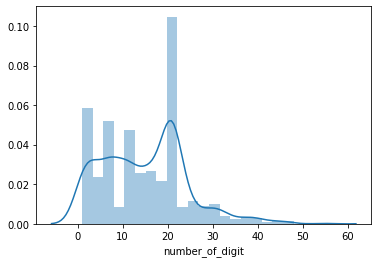

In [59]:
#istogramma per valutare le performance
from seaborn import distplot
distplot(award_crossYear_allFounded.number_of_digit)

In [60]:
#in base ai risiltati e alle preview, tutti quelli con numero di digit < 6 si considerano non identificati:
#ad esempio, ci sono titoli con una lettera, in quei casi e chiaro che non sia una buona pratica 
award_crossYear_good = award_crossYear_allFounded.copy()[award_crossYear_allFounded['number_of_digit'] >= 5].drop(
    ['number_of_digit', 'all_years', 'season_number', 'source'], axis = 1)
award_crossYear_good['source'] = 'cross_year'
award_crossYear_bad = award_crossYear_allFounded.copy()[award_crossYear_allFounded['number_of_digit'] < 5].drop(
    ['number_of_digit', 'all_years', 'season_number', 'year_title', 'source'], axis = 1)

In [61]:
print('Trovati title: ' + str(len(award_crossYear_allFounded.award_id.unique())))
print('Totali: ' + str(len(award_notFounded_api.award_id.unique())))

Trovati title: 499
Totali: 613


In [62]:
#aggrego l'elenco di anni in una lista 
award_crossYear_good = award_crossYear_good[['award_id','title_id','year_title']].drop_duplicates().groupby(
    ['award_id','title_id']
)['year_title'].apply(list).reset_index().sort_values(['award_id','title_id'])
award_crossYear_good.columns = ['award_id', 'title_id', 'year_title']
award_crossYear_good.head()

,award_id,title_id,year_title
0,aw-16425,tv-1358,"[2004.0, 2005.0, 2006.0]"
1,aw-16562,tv-845,"[1976.0, 1977.0]"
2,aw-16567,tv-845,"[1975.0, 1976.0, 1977.0]"
3,aw-16581,tv-845,"[1972.0, 1973.0, 1974.0]"
4,aw-16586,tv-845,"[1971.0, 1972.0, 1973.0]"


In [63]:
#faccio la stessa cosa per il dataset delle stagioni
tv_seasons_year = tv_seasons.copy()[['title_id','year_title']].drop_duplicates().groupby(
    ['title_id']
)['year_title'].apply(list).reset_index().sort_values(['title_id']).merge(tv_series_original[['title_id', 'popularity']], how = 'left', on = 'title_id')

tv_seasons_year.head()

,title_id,year_title,popularity
0,tv-1,[2004.0],8.111
1,tv-10,"[1985.0, 1987.0, 1988.0]",5.186
2,tv-100,[1983.0],11.896
3,tv-1000,[1993.0],0.600
4,tv-10000,[1991.0],3.455


In [64]:
#funzione per la concatenazione di tre liste
def concat_list(first, last, season):
    first = [first] if pd.notnull(first) else []
    last = [last] if pd.notnull(last) else []
    try:
        season = season if pd.notnull(season) else []
    except:
        season
    return first + last + season

#dateset con la lista creata in precedenza, anno della first air date e della last air date
tv_years = tv_series_original.copy()[['title_id','first_year','last_year']].merge(
    tv_seasons_year, how = 'left', on = 'title_id').reset_index(drop = True)

#creo una lista unica
tv_years['year_title'] = [concat_list(x[0], x[1], x[2]) for x in zip(tv_years['last_year'], tv_years['first_year'], tv_years['year_title'])]

#verticalizzo
tv_years = tv_years.copy()[['title_id', 'year_title']].explode('year_title').drop_duplicates().merge(
    tv_series, how = 'left', on = 'title_id')
tv_years.head()

,title_id,year_title,title,original_title
0,tv-1,2004,PRIDE,プライド
1,tv-2,2002,CLERKS: THE ANIMATED SERIES,CLERKS: THE ANIMATED SERIES
2,tv-2,2000,CLERKS: THE ANIMATED SERIES,CLERKS: THE ANIMATED SERIES
3,tv-3,2006,THE MESSAGE,THE MESSAGE
4,tv-4,2006,THE AMAZING MRS PRITCHARD,THE AMAZING MRS PRITCHARD


In [65]:
#recupero anno e popolarita mantenendo uppercase
movie_years = tmdb_movies_complete.copy()[['title_id', 'year_title', 'popularity']].merge(
    tmdb_movies, how = 'left', on = 'title_id')
movie_years.head()

,title_id,year_title,popularity,original_title,title
0,m-1,1938.0,2.620,BLONDIE,BLONDIE
1,m-2,1921.0,0.600,DER MANN OHNE NAMEN,"PETER VOSS, THIEF OF MILLIONS"
2,m-3,1962.0,3.430,L'AMOUR À VINGT ANS,LOVE AT TWENTY
3,m-4,2003.0,0.600,JATTS IN GOLMAAL,JATTS IN GOLMAAL
4,m-5,2008.0,0.921,NEW WORLD DISORDER 9: NEVER ENOUGH,NEW WORLD DISORDER 9: NEVER ENOUGH


In [66]:
#concateno i due df e se non ho la popolarita' la considero pari a zero
title_years = pd.concat([movie_years, tv_years])
title_years['popularity'] = title_years['popularity'].fillna(0)
title_years.head()

,title_id,year_title,popularity,original_title,title
0,m-1,1938,2.620,BLONDIE,BLONDIE
1,m-2,1921,0.600,DER MANN OHNE NAMEN,"PETER VOSS, THIEF OF MILLIONS"
2,m-3,1962,3.430,L'AMOUR À VINGT ANS,LOVE AT TWENTY
3,m-4,2003,0.600,JATTS IN GOLMAAL,JATTS IN GOLMAAL
4,m-5,2008,0.921,NEW WORLD DISORDER 9: NEVER ENOUGH,NEW WORLD DISORDER 9: NEVER ENOUGH


In [67]:
#merge cross year il dataset degli anni
award_crossYear_good = award_crossYear_good.drop(columns = 'year_title', index = 1).merge(
    title_years.drop(columns = ['year_title', 'popularity'], index = 1), how = 'left', on = 'title_id').merge(
    data_award, how = 'left', on = 'award_id')
award_crossYear_good.head()

,award_id,title_id,original_title,title,award,year,program,person,is_winner,type,award_type,title_upper
0,aw-16425,tv-1358,DEADWOOD,DEADWOOD,Drama - Drama Series,2005.0,Deadwood: The Movie,"[Ed Bianchi, Gregg Fienberg, Ted Mann, David M...",Nominee,T,emmy award,DEADWOOD: THE MOVIE
1,aw-16425,tv-1358,DEADWOOD,DEADWOOD,Drama - Drama Series,2005.0,Deadwood: The Movie,"[Ed Bianchi, Gregg Fienberg, Ted Mann, David M...",Nominee,T,emmy award,DEADWOOD: THE MOVIE
2,aw-16425,tv-1358,DEADWOOD,DEADWOOD,Drama - Drama Series,2005.0,Deadwood: The Movie,"[Ed Bianchi, Gregg Fienberg, Ted Mann, David M...",Nominee,T,emmy award,DEADWOOD: THE MOVIE
3,aw-16567,tv-845,COLUMBO,COLUMBO,Drama - Drama Series,1976.0,Columbo NBC Sunday Mystery Movie,[Everett Chambers],Nominee,T,emmy award,COLUMBO NBC SUNDAY MYSTERY MOVIE
4,aw-16567,tv-845,COLUMBO,COLUMBO,Drama - Drama Series,1976.0,Columbo NBC Sunday Mystery Movie,[Everett Chambers],Nominee,T,emmy award,COLUMBO NBC SUNDAY MYSTERY MOVIE


In [68]:
#concatenazione di tutti i trovati e merge con il dataset degli anni
award_merged_all = pd.concat([
    award_title_founded,
    award_originalTitle_founded,
    award_titleCleaned_founded,
    award_originalTitleCleaned_founded,
    award_title_founded_TM,
    award_originalTitle_founded_TM,
    award_titleCleaned_founded_TM,
    award_originalTitleCleaned_founded_TM,
    award_founded_api,
    award_crossYear_good
], sort = True).drop(columns = ['type'], index = 1).merge(
    title_years[['year_title', 'title_id']], how = 'left', on = 'title_id')
award_merged_all.head()

#sopra faccio lo stesso merge, si poteva fare anche solo una volta...

,award,award_id,award_type,is_winner,original_title,person,program,source,title,title_cleaned,title_id,title_upper,year,year_title
0,Comedy - Comedy Series,aw-14028,emmy award,Nominee,BARRY,"[Alec Berg, Bill Hader, Aida Rodgers, Emily He...",Barry,upper_title,BARRY,NaN,tv-66571,BARRY,2019.0,2019
1,Comedy - Comedy Series,aw-14028,emmy award,Nominee,BARRY,"[Alec Berg, Bill Hader, Aida Rodgers, Emily He...",Barry,upper_title,BARRY,NaN,tv-66571,BARRY,2019.0,2018
2,Comedy - Comedy Series,aw-14030,emmy award,Nominee,RUSSIAN DOLL,"[Natasha Lyonne, Leslye Headland, Amy Poehler,...",Russian Doll,upper_title,RUSSIAN DOLL,NaN,tv-76091,RUSSIAN DOLL,2019.0,2019
3,Comedy - Comedy Series,aw-14031,emmy award,Nominee,SCHITT'S CREEK,"[Eugene Levy, Daniel Levy, David West Read, An...",Schitt's Creek,upper_title,SCHITT'S CREEK,NaN,tv-57551,SCHITT'S CREEK,2019.0,2020
4,Comedy - Comedy Series,aw-14031,emmy award,Nominee,SCHITT'S CREEK,"[Eugene Levy, Daniel Levy, David West Read, An...",Schitt's Creek,upper_title,SCHITT'S CREEK,NaN,tv-57551,SCHITT'S CREEK,2019.0,2015


In [69]:
#premi non trovati
award_notFounded = data_award.copy()[
    data_award['award_id'].isin(award_merged_all['award_id'].tolist())==False
]

In [70]:
print('Non trovati: ' + str(award_notFounded.shape[0]))

Non trovati: 188


# Deduplica

In [71]:
print('Record totali con duplicati: ' + str(award_merged_all.shape[0]))
#eliminazione dei record con duplicati per le terne premio, titolo e anno:
#significa che diversi metodi hanno portato allo stesso risultato
award_merged_all = award_merged_all.drop_duplicates(['award_id', 'title_id', 'year_title'])

print('Record totali non duplicati: ' + str(award_merged_all.shape[0]))
print('Numero di premi: ' + str(award_merged_all.drop_duplicates('title_id').shape[0]))

Record totali con duplicati: 552098
Record totali non duplicati: 171255
Numero di premi: 9054


In [72]:
award_merged_all.head()

,award,award_id,award_type,is_winner,original_title,person,program,source,title,title_cleaned,title_id,title_upper,year,year_title
0,Comedy - Comedy Series,aw-14028,emmy award,Nominee,BARRY,"[Alec Berg, Bill Hader, Aida Rodgers, Emily He...",Barry,upper_title,BARRY,NaN,tv-66571,BARRY,2019.0,2019
1,Comedy - Comedy Series,aw-14028,emmy award,Nominee,BARRY,"[Alec Berg, Bill Hader, Aida Rodgers, Emily He...",Barry,upper_title,BARRY,NaN,tv-66571,BARRY,2019.0,2018
2,Comedy - Comedy Series,aw-14030,emmy award,Nominee,RUSSIAN DOLL,"[Natasha Lyonne, Leslye Headland, Amy Poehler,...",Russian Doll,upper_title,RUSSIAN DOLL,NaN,tv-76091,RUSSIAN DOLL,2019.0,2019
3,Comedy - Comedy Series,aw-14031,emmy award,Nominee,SCHITT'S CREEK,"[Eugene Levy, Daniel Levy, David West Read, An...",Schitt's Creek,upper_title,SCHITT'S CREEK,NaN,tv-57551,SCHITT'S CREEK,2019.0,2020
4,Comedy - Comedy Series,aw-14031,emmy award,Nominee,SCHITT'S CREEK,"[Eugene Levy, Daniel Levy, David West Read, An...",Schitt's Creek,upper_title,SCHITT'S CREEK,NaN,tv-57551,SCHITT'S CREEK,2019.0,2015


In [73]:
#pulizia titoli presenti nei dataset
award_merged_all['title_upper_cleaned'] = award_merged_all['title_upper'].apply(
    lambda row: replace_na_string(regex_replace(r'[^A-Z]', '', row)))

award_merged_all['title_cleaned'] = award_merged_all['title'].apply(
    lambda row: replace_na_string(regex_replace(r'[^A-Z]', '', row)))

award_merged_all['original_title_cleaned'] = award_merged_all['original_title'].apply(
    lambda row: replace_na_string(regex_replace(r'[^A-Z]', '', row)))


In [74]:
award_merged_all.head()

,award,award_id,award_type,is_winner,original_title,person,program,source,title,title_cleaned,title_id,title_upper,year,year_title,title_upper_cleaned,original_title_cleaned
0,Comedy - Comedy Series,aw-14028,emmy award,Nominee,BARRY,"[Alec Berg, Bill Hader, Aida Rodgers, Emily He...",Barry,upper_title,BARRY,BARRY,tv-66571,BARRY,2019.0,2019,BARRY,BARRY
1,Comedy - Comedy Series,aw-14028,emmy award,Nominee,BARRY,"[Alec Berg, Bill Hader, Aida Rodgers, Emily He...",Barry,upper_title,BARRY,BARRY,tv-66571,BARRY,2019.0,2018,BARRY,BARRY
2,Comedy - Comedy Series,aw-14030,emmy award,Nominee,RUSSIAN DOLL,"[Natasha Lyonne, Leslye Headland, Amy Poehler,...",Russian Doll,upper_title,RUSSIAN DOLL,RUSSIANDOLL,tv-76091,RUSSIAN DOLL,2019.0,2019,RUSSIANDOLL,RUSSIANDOLL
3,Comedy - Comedy Series,aw-14031,emmy award,Nominee,SCHITT'S CREEK,"[Eugene Levy, Daniel Levy, David West Read, An...",Schitt's Creek,upper_title,SCHITT'S CREEK,SCHITTSCREEK,tv-57551,SCHITT'S CREEK,2019.0,2020,SCHITTSCREEK,SCHITTSCREEK
4,Comedy - Comedy Series,aw-14031,emmy award,Nominee,SCHITT'S CREEK,"[Eugene Levy, Daniel Levy, David West Read, An...",Schitt's Creek,upper_title,SCHITT'S CREEK,SCHITTSCREEK,tv-57551,SCHITT'S CREEK,2019.0,2015,SCHITTSCREEK,SCHITTSCREEK


In [75]:
#recupero popolarita'
award_merged = award_merged_all.copy().merge(
    all_titles_pop,
    how = 'left', on = 'title_id'
)
#ranking per popolarita'
award_merged['rank_pop'] = award_merged.groupby("award_id")["popularity"].rank(method="first", ascending=False)

In [76]:
#per la deduplica si applica la funzione di risoluzione utilizzata anche nell'enrichment dei film

#definizione dei livelli di priorita' attraverso un "indice di priorita'",
#l'indice si inizializza a zero e poi viene aggiornato nel modo seguente:
#se hanno lo stesso titolo l'indice aumenta di 2
#se il titolo del film e' contenuto nel titolo del df dei premi (titoli ripuliti e non), l'indice aumenta di 1
#se hanno lo stesso anno, l'indice aumenta di 1
#se la serie tv (o il film in alcuni casi) e' il primo nel ranking della popolarita' (ossia quello con popolarita' massima), l'indice aumenta di 1

#ad ogni iterazione si aggiorna anche il flag corrispondente all'aumento

award_merged['same_title'] = False
award_merged['title_is_in'] = False
award_merged['same_year'] = False
award_merged['title_cleaned_is_in'] = False
award_merged['is_max_pop'] = False
award_merged['priority'] = 0

In [77]:
for i in range(award_merged.shape[0]):
    
    #estraggo attributi rilevanti (per non incasinare il codice..)
    original_title = award_merged['original_title'].iloc[i]
    title = award_merged['title'].iloc[i]
    title_upper = award_merged['title_upper'].iloc[i]
    original_title_cleaned = award_merged['original_title_cleaned'].iloc[i]
    title_cleaned = award_merged['title_cleaned'].iloc[i]
    title_upper_cleaned = award_merged['title_upper_cleaned'].iloc[i]
    year = award_merged['year'].iloc[i]
    year_movie = award_merged['year_title'].iloc[i]
    
    #same title
    if (original_title == title_upper) | (title == title_upper):
        award_merged['same_title'].iloc[i] = True
        award_merged['priority'].iloc[i] += 2
    
    #title is in
    if pd.notnull(title):
        if (title in title_upper) | (title_upper in title):
            award_merged['title_is_in'].iloc[i] = True
            award_merged['priority'].iloc[i] += 1
    if (not award_merged['title_is_in'].iloc[i]) & pd.notnull(original_title):
        if (original_title in title_upper) | (title_upper in original_title):
            award_merged['title_is_in'].iloc[i] = True
            award_merged['priority'].iloc[i] += 1
            
    #title cleaned is in
    if pd.notnull(title_cleaned) & pd.notnull(title_upper_cleaned):
        if (title_cleaned in title_upper_cleaned) | (title_upper_cleaned in title_cleaned):
            award_merged['title_cleaned_is_in'].iloc[i] = True
            award_merged['priority'].iloc[i] += 1
    if (not award_merged['title_cleaned_is_in'].iloc[i]) & pd.notnull(original_title_cleaned) & pd.notnull(title_upper_cleaned):
        if (original_title_cleaned in title_upper_cleaned) | (title_upper_cleaned in original_title_cleaned):
            award_merged['title_cleaned_is_in'].iloc[i] = True
            award_merged['priority'].iloc[i] += 1
    
    #same year
    if year == year_movie:
        award_merged['same_year'].iloc[i] = True
        award_merged['priority'].iloc[i] += 1
    elif abs(year - year_movie) > 2:
        award_merged['priority'].iloc[i] -=1
        
    #max pop
    if award_merged['rank_pop'].iloc[i] == 1:
        award_merged['is_max_pop'].iloc[i] = True
        award_merged['priority'].iloc[i] += 1

C:\root\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [78]:
#escludo quelli con priorita' pari a zero
award_merged_priority = award_merged.copy()[award_merged['priority'] > 0]

In [85]:
#frequenza dell'indice di priorita'
pd.DataFrame(
    award_merged_priority.groupby(['priority']).size()
).reset_index()

,priority,0
0,1,47797
1,2,11481
2,3,37311
3,4,25862
4,5,8703
5,6,1509


In [79]:
#riordino ed elimino i duplicati (di default viene tenuto il primo record, ossia quello con priorita' massima),
#se ci sono due programmi con stessa priorita' si prende il piu popolare
award_merged_max_pp = award_merged_priority.sort_values(['award_id', 'priority', 'popularity'], ascending = False).drop_duplicates('award_id')

In [80]:
award_merged_max_pp.head()

,award,award_id,award_type,is_winner,original_title,person,program,source,title,title_cleaned,...,title_upper_cleaned,original_title_cleaned,popularity,rank_pop,same_title,title_is_in,same_year,title_cleaned_is_in,is_max_pop,priority
67013,Television Series,aw-24537,golden globe,Winner,WHAT'S MY LINE?,[],What's My Line?,upper_title,WHAT'S MY LINE?,WHATSMYLINE,...,WHATSMYLINE,WHATSMYLINE,21.518,1.0,True,True,False,True,True,4
67002,Television Series,aw-24536,golden globe,Winner,MY THREE SONS,[],My Three Sons,upper_title,MY THREE SONS,MYTHREESONS,...,MYTHREESONS,MYTHREESONS,25.499,3.0,True,True,True,True,False,5
66996,Actress In A Television Series,aw-24535,golden globe,Winner,THE DONNA REED SHOW,[Donna Reed],The DONNA REED SHOW,upper_title,THE DONNA REED SHOW,THEDONNAREEDSHOW,...,THEDONNAREEDSHOW,THEDONNAREEDSHOW,20.347,6.0,True,True,True,True,False,5
66987,Actor In A Television Series,aw-24534,golden globe,Winner,DR. KILDARE,[Richard Chamberlain],Dr. Kildare,upper_title,DR. KILDARE,DRKILDARE,...,DRKILDARE,DRKILDARE,25.511,3.0,True,True,True,True,False,5
165323,Television Series - Comedy,aw-24533,golden globe,Winner,MISTER ED,[],Mr. Ed,api_tv,MISTER ED,MISTERED,...,MRED,MISTERED,13.412,4.0,False,False,True,False,False,1


In [90]:
#frequenza dell'indice di priorita'
pd.DataFrame(
    award_merged_max_pp.groupby(['priority']).size()
).reset_index()

,priority,0
0,1,215
1,2,330
2,3,619
3,4,607
4,5,6915
5,6,1509


In [81]:
#estrazione dei premi non trovati (ossia quelli che non hanno nessu programma con priorita' diversa da zero)
award_merged_max_pp_not_founded = award_merged[['award', 'year', 'program', 'person', 'is_winner', 'award_type', 'title_upper', 'award_id']
            ].merge(award_merged_max_pp[['award_id', 'title_id']], how = 'left', on = 'award_id')
award_merged_max_pp_not_founded = award_merged_max_pp_not_founded[
    pd.isnull(award_merged_max_pp_not_founded['title_id'])
].drop_duplicates('award_id')

In [82]:
award_merged_max_pp_not_founded.shape[0]

124

In [83]:
print('Trovati correttamente: ' + str(award_merged_max_pp.shape[0]))
#print('Trovati dubbi in quanto anno troppo diverso: ' + str(len(award_merged_year_minMax_notFounded.award_id.unique())))
print('Non trovati: ' + str(award_notFounded.shape[0] + award_merged_max_pp_not_founded.shape[0]))
print('Premi totali con titolo non vuoto: ' + str(data_award.shape[0]))

Trovati correttamente: 10195
Non trovati: 312
Premi totali con titolo non vuoto: 10507


In [84]:
award_notFounded['title_id'] = None
award_merged_max_pp_not_founded['title_id'] = None
pd.concat([
award_merged_max_pp[
    ['award', 'award_id', 'award_type', 'is_winner', 'person', 'title_id','year']
], award_notFounded[['award', 'award_id', 'award_type', 'is_winner', 'person', 'title_id','year']],
    award_merged_max_pp_not_founded[['award', 'award_id', 'award_type', 'is_winner', 'person', 'title_id','year']]
]).to_pickle(path_data + 'awards/integrated/award_tvseries_final.df')